In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
# Hyperparameter
batch_size = 64
z_dim = 128
learning_rate_gen = 5e-5
learning_rate_dis = 5e-5
max_step = 20000
n_dis = 5
# lambda (gradient panelty)
lam = 10.

In [0]:
# Define Generator Network
def generator(x, reuse = False):
    with tf.variable_scope('generator', reuse = reuse):
        fc1 = tf.layers.dense(x, 
                              units = 5 * 5 * 256, 
                              activation = tf.nn.leaky_relu)
        fc1 = tf.layers.batch_normalization(fc1)
        fc1 = tf.reshape(fc1, [-1, 5, 5, 256])

        # First Convolutional Layer
        conv1 = tf.layers.conv2d_transpose(fc1, 
                                           filters = 128, 
                                           kernel_size = 5,
                                           strides = 2,
                                           activation = tf.nn.leaky_relu)
        conv1 = tf.layers.batch_normalization(conv1)

        # Second Convolutional Layer
        conv2 = tf.layers.conv2d(conv1, 
                                 filters = 128, 
                                 kernel_size = 3, 
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv2 = tf.layers.batch_normalization(conv2)


        # Third Convolutional Layer (Output Layer with tanh activation)
        output = tf.layers.conv2d_transpose(conv2, 
                                            filters = 1, 
                                            kernel_size = 4, 
                                            strides = 2,
                                            activation = tf.nn.tanh)
        
        return output

In [0]:
# Define Discriminator Network
def discriminator(x, reuse = False):
    with tf.variable_scope('discriminator', reuse = reuse):
        # First Convolutional Layer
        conv1 = tf.layers.conv2d(x, 
                                 filters = 256, 
                                 kernel_size = 4, 
                                 strides = 2,
                                 activation = tf.nn.leaky_relu)
        conv1 = tf.layers.batch_normalization(conv1)
        
        conv2 = tf.layers.conv2d(conv1, 
                                 filters = 128, 
                                 kernel_size = 3, 
                                 strides = 1, 
                                 padding = 'same', 
                                 activation = tf.nn.leaky_relu)
        
        conv2 = tf.layers.batch_normalization(conv2, momentum = 0.9)
        
        output = tf.layers.flatten(conv2)
        
        output = tf.layers.dense(output, 
                                 units = 1)
        return output

In [0]:
# Input
gen_input = tf.placeholder(tf.float32, shape = [None, z_dim], name = 'gen_input')
dis_input = tf.placeholder(tf.float32, shape = [None, 28, 28, 1], name = 'dis_input')
fake_input = generator(gen_input)

# Logits
true_logit = discriminator(dis_input)
fake_logit = discriminator(fake_input, reuse = True)
dis_loss = tf.reduce_mean(fake_logit - true_logit)
gen_loss = tf.reduce_mean(- fake_logit)

# Variables
gen_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
dis_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')

## Gradient Penalty

# Generate Interpolated Samples
uniform_dist = tf.contrib.distributions.Uniform(low=0., high=1.)
alpha = uniform_dist.sample((batch_size, 1, 1, 1))
interpolated = dis_input + alpha * (fake_input - dis_input)

# Calculate Gradients
int_logit = discriminator(interpolated, reuse = True)
gradients = tf.gradients(int_logit, [interpolated, ])[0]
gradients_l2 = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis = [1, 2, 3]))

# Panelty
gradient_penalty = lam * tf.reduce_mean((gradients_l2 - 1) ** 2)
dis_loss += gradient_penalty

# Optimizer (RMSProp)
gen_opt = tf.train.RMSPropOptimizer(learning_rate_gen).minimize(gen_loss, var_list = gen_var)
dis_opt = tf.train.RMSPropOptimizer(learning_rate_dis).minimize(dis_loss, var_list = dis_var)

# Initialization
init = tf.global_variables_initializer()

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(max_step):
    
    for j in range(n_dis):
        batch_x, _ = mnist.train.next_batch(batch_size)
        batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
        z = np.random.normal(0., 1., size=[batch_size, z_dim])
        feed_dict = {gen_input: z, dis_input: batch_x}
        sess.run([dis_opt], feed_dict = feed_dict)
        
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    z = np.random.normal(0., 1., size=[batch_size, z_dim])
    feed_dict = {gen_input: z, dis_input: batch_x}
    _, d_loss, g_loss, p = sess.run([gen_opt, dis_loss, gen_loss, gradient_penalty], feed_dict = feed_dict)
    if i % 200 == 0:
        print ('step {}: {}, {}, {}'.format(i, d_loss, g_loss, p))

step 0: 8.67988109588623, 3.702970570884645e-05, 8.65532112121582
step 200: -7.244150161743164, -1.0009503364562988, 0.9515646696090698
step 400: -5.312089443206787, -9.259130477905273, 0.7441104650497437
step 600: -4.058737754821777, -16.906526565551758, 0.38236820697784424
step 800: -3.0577986240386963, -19.627933502197266, 0.2637513279914856
step 1000: -2.664249897003174, -19.350088119506836, 0.25065433979034424
step 1200: -2.650815010070801, -14.784847259521484, 0.16094915568828583
step 1400: -2.3050575256347656, -11.606674194335938, 0.15002095699310303
step 1600: -2.253739356994629, -10.665695190429688, 0.26159340143203735
step 1800: -2.467317581176758, -10.163230895996094, 0.22030535340309143
step 2000: -2.3082289695739746, -8.942683219909668, 0.2512784004211426
step 2200: -2.189283609390259, -8.98878002166748, 0.19522474706172943
step 2400: -1.8762521743774414, -7.5268778800964355, 0.19874447584152222
step 2600: -1.9820380210876465, -7.553017616271973, 0.17239853739738464
step 2

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


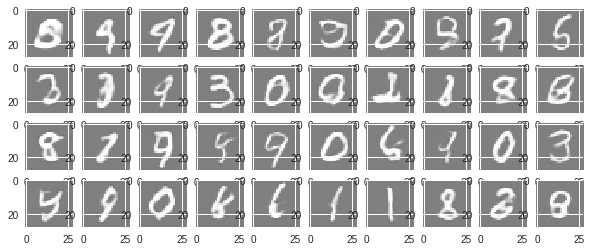

In [11]:
# Generate images from noise, using the generator network.
f, a = plt.subplots(4, 10, figsize=(10, 4))
for i in range(10):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[4, z_dim])
    g = sess.run(fake_input, feed_dict={gen_input: z})
    g = (g + 1) / 2
    for j in range(4):
        # Generate image from noise. Extend to 3 channels for matplot figure.
        img = np.reshape(np.repeat(g[j][:, :, np.newaxis], 3, axis=2),
                         newshape=(28, 28, 3))
        a[j][i].imshow(img)

f.show()
plt.draw()